In [11]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Load the dataset
stock_data = pd.read_csv('stock_data.csv', parse_dates=['Date'],skiprows = [1])
stock_data.set_index('Date', inplace=True)

# Display the first few rows
stock_data.head()



Saving stock_data.csv to stock_data (2).csv


,Close,High,Low,Open,Volume,MA_20,MA_50,RSI,MACD,Signal_Line,Returns
Date,,,,,,,,,,,
02-01-2020,72.796036,72.856628,71.545402,71.799888,135480400,NaN,NaN,NaN,0.000000,0.000000,NaN
03-01-2020,72.088295,72.851761,71.862892,72.020432,146322800,NaN,NaN,NaN,-0.056458,-0.011292,-0.009722
06-01-2020,72.662712,72.701492,70.954002,71.206070,118387200,NaN,NaN,NaN,-0.054226,-0.019878,0.007968
07-01-2020,72.320961,72.929306,72.100403,72.672394,108872000,NaN,NaN,NaN,-0.079121,-0.031727,-0.004703
08-01-2020,73.484383,73.787346,72.022887,72.022887,132079200,NaN,NaN,NaN,-0.004915,-0.026365,0.016087


In [12]:
import pickle

# Upload the trained model
uploaded = files.upload()

# Load the model
with open('trained_model.pkl', 'rb') as file:
    model = pickle.load(file)



Saving trained_model.pkl to trained_model (1).pkl


In [13]:
# List of features used in model training
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'MA_20', 'MA_50', 'RSI', 'MACD', 'Signal_Line', 'Returns']

# Ensure all necessary features are in the dataset
missing_features = [feature for feature in features if feature not in stock_data.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    # Generate predictions
    stock_data['Predicted'] = model.predict(stock_data[features])

# Verify predictions
stock_data[['Predicted']].head()


,Predicted
Date,
02-01-2020,1
03-01-2020,1
06-01-2020,1
07-01-2020,1
08-01-2020,1


In [14]:
# Add trading signals: 1 for Buy, -1 for Sell, 0 for Hold
stock_data['Signal'] = stock_data['Predicted'].diff().fillna(0)

# Calculate daily returns
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# Implement the strategy returns, including transaction costs (0.1%)
transaction_cost = 0.001
stock_data['Strategy_Return'] = stock_data['Signal'].shift(1) * stock_data['Daily_Return']
stock_data['Strategy_Return'] -= abs(stock_data['Signal'].shift(1)) * transaction_cost

# Calculate cumulative returns
initial_capital = 10000
stock_data['Cumulative_Strategy'] = (1 + stock_data['Strategy_Return']).cumprod() * initial_capital
stock_data['Cumulative_Buy_and_Hold'] = (1 + stock_data['Daily_Return']).cumprod() * initial_capital


In [15]:
# Sharpe Ratio
risk_free_rate = 0.02 / 252  # 2% annual risk-free rate
strategy_std = stock_data['Strategy_Return'].std()
strategy_mean = stock_data['Strategy_Return'].mean()
sharpe_ratio = (strategy_mean - risk_free_rate) / strategy_std

# Maximum Drawdown
cumulative = stock_data['Cumulative_Strategy']
drawdown = cumulative / cumulative.cummax() - 1
max_drawdown = drawdown.min()

# Print performance metrics
print(f"Cumulative Returns (Strategy): {stock_data['Cumulative_Strategy'].iloc[-1] - initial_capital:.2f}")
print(f"Cumulative Returns (Buy-and-Hold): {stock_data['Cumulative_Buy_and_Hold'].iloc[-1] - initial_capital:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Cumulative Returns (Strategy): 586780.93
Cumulative Returns (Buy-and-Hold): 7662.76
Sharpe Ratio: 0.38
Maximum Drawdown: -9.98%


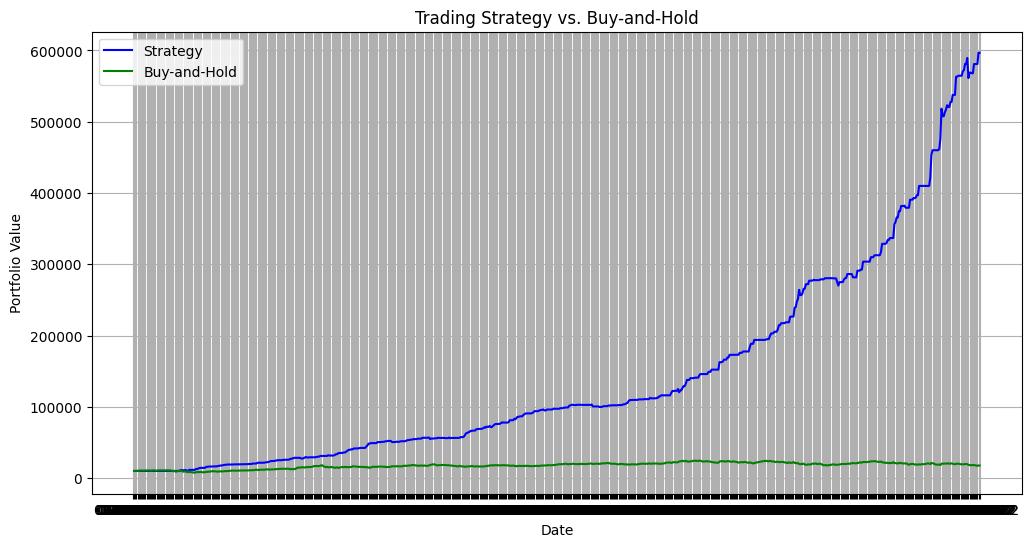

In [16]:
import matplotlib.pyplot as plt

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Cumulative_Strategy'], label='Strategy', color='blue')
plt.plot(stock_data.index, stock_data['Cumulative_Buy_and_Hold'], label='Buy-and-Hold', color='green')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Trading Strategy vs. Buy-and-Hold')
plt.legend()
plt.grid()
plt.show()


In [17]:
# Save performance metrics as a report
report = {
    'Metric': ['Cumulative Returns (Strategy)', 'Cumulative Returns (Buy-and-Hold)', 'Sharpe Ratio', 'Maximum Drawdown'],
    'Value': [
        stock_data['Cumulative_Strategy'].iloc[-1] - initial_capital,
        stock_data['Cumulative_Buy_and_Hold'].iloc[-1] - initial_capital,
        sharpe_ratio,
        max_drawdown
    ]
}

report_df = pd.DataFrame(report)
report_df.to_csv('strategy_report.csv', index=False)

# Download the report
files.download('strategy_report.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>